In [3]:
import sys
sys.path.insert(0, "/mnt/arquivos_linux/wile_C/Predictive_Maintenance_free_dataset/")
import torch
from matplotlib.pyplot import figure
from datasets import DatasetSinteticUnsupervisedLSTM

figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [7]:
absolut_path = "../Datasets/sintetic_dataset/fusion_transformer_result/26000"

data_ground_truth = torch.load(f"{absolut_path}/actuals.pt")
data_predicted = torch.load(f"{absolut_path}/predicted.pt")

In [8]:
data_predicted.shape, data_ground_truth.shape

(torch.Size([9184, 100, 7]), torch.Size([9184, 100]))

### First channel

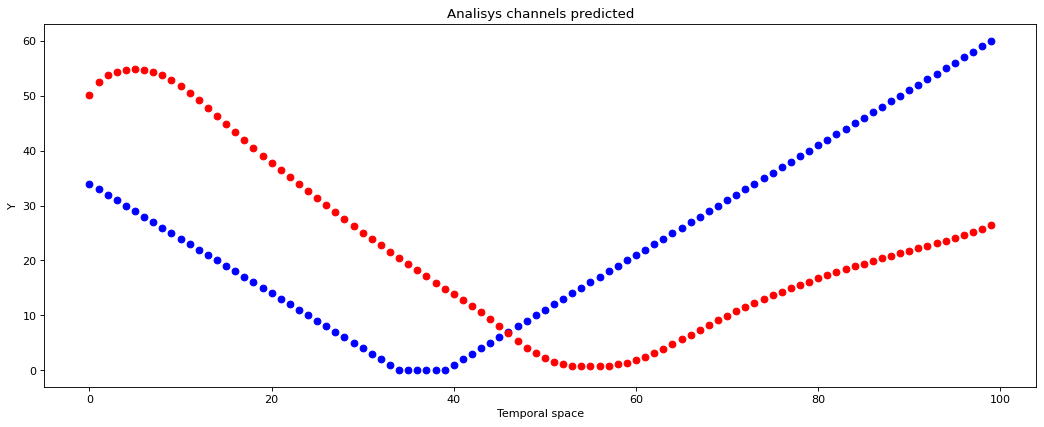

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(16, 6), dpi=80)
init_limiter = 0

middle = 3
slice_data = 5

feature_channel = 0
plt.xlabel('Temporal space')
plt.ylabel('Y')
plt.title("Analisys channels predicted")
#plt.plot(data_ground_truth[slice_data], color='blue', label='sinal Real')
#plt.plot(data_predicted[slice_data, :, 3], color='r', label='sinal previsto')

plt.plot(data_ground_truth[slice_data], "o", color='blue', label='sinal Real')
plt.plot(data_predicted[slice_data, :, 3], "o", color='r', label='sinal previsto')

In [12]:
slice_data_true = data_ground_truth[slice_data]
slice_data_pred = data_predicted[slice_data, :, middle]

abs_data = abs(slice_data_true - slice_data_pred)
abs_data

tensor([16.1790, 19.5090, 21.6949, 23.3696, 24.7293, 25.8640, 26.7751, 27.4154,
        27.7687, 27.8714, 27.7816, 27.5532, 27.2266, 26.8293, 26.3817, 25.9029,
        25.4135, 24.9353, 24.4880, 24.0855, 23.7324, 23.4232, 23.1442, 22.8765,
        22.6032, 22.3172, 22.0248, 21.7407, 21.4788, 21.2469, 21.0468, 20.8770,
        20.7339, 20.6108, 20.4967, 19.3786, 18.2487, 17.1131, 15.9894, 14.8925,
        12.8249, 10.7743,  8.7131,  6.6012,  4.3971,  2.0853,  0.2877,  2.6260,
         4.8526,  6.9339,  8.8351, 10.5048, 11.9330, 13.1697, 14.2777, 15.2988,
        16.2498, 17.1291, 17.9223, 18.6083, 19.1685, 19.5970, 19.9052, 20.1187,
        20.2690, 20.3863, 20.4953, 20.6127, 20.7479, 20.9047, 21.0845, 21.2880,
        21.5163, 21.7710, 22.0533, 22.3636, 22.7005, 23.0618, 23.4441, 23.8443,
        24.2597, 24.6888, 25.1319, 25.5905, 26.0666, 26.5614, 27.0744, 27.6034,
        28.1444, 28.6927, 29.2428, 29.7894, 30.3277, 30.8534, 31.3633, 31.8550,
        32.3272, 32.7795, 33.2126, 33.62

In [13]:
data_ground_truth.shape

torch.Size([9184, 100])

In [14]:
from soft_dtw_cuda import SoftDTW

sdtw = SoftDTW(use_cuda=True, gamma=0.1)

def smape_loss(y_pred, target):
    # y_pred = y_pred.squeeze(2)
    loss = 2 * abs((y_pred - target)) / (abs(y_pred) + abs(target) + 1e-8)
    return loss.mean()*100

In [15]:
# def soft_dtw(y_pred, target):
#     #loss = sdtw(y_pred.unsqueeze(2), target.unsqueeze(2))
#     loss = sdtw(y_pred[np.newaxis, :, np.newaxis],
#                 target[np.newaxis, :, np.newaxis])
    
#     return loss.mean()

slice_data_true = data_ground_truth[slice_data]
slice_data_pred = data_predicted[slice_data, :, middle]

abs_data = abs(slice_data_true - slice_data_pred)
# Mean absolut error
print(f"Mean absolut error: {abs_data.mean()}")

sum_square = 0
for i, elem in enumerate(slice_data_true):
    sum_square += (slice_data_true[i] - slice_data_pred[i])**2

sum_square = sum_square/(i+1)
    
#Mean square error
print(f"Mean square error: {sum_square}")

#SMAPE
print(f"smape loss: {smape_loss(slice_data_true, slice_data_pred)}")

#soft DTW

# soft_dtw(slice_data_true, slice_data_pred)

Mean absolut error: 21.24298667907715
Mean square error: 501.38507080078125
smape loss: 107.87274932861328


In [11]:
import numpy as np
# In terms of interpreting the SMAPE, a value of zero indicates perfect accuracy,
# while larger values indicate greater forecasting error. A SMAPE of 100%
# indicates that the model's forecasts are completely off-base,
# predicting values that are twice the actual values on average.


print(f"differents form: {smape_loss(np.arange(1,100), np.arange(100,1, -1))}")
print(f"same form: {smape_loss(np.arange(1,100), np.arange(1, 100))}")

differents form: 98.02980297059212
same form: 0.0


In [12]:
def transform_for_days(x):
    x = (((x*10)/60)/60)/24
    return x

def transform_for_hour(x):
    x = (x*24)
    return x

def transform_for_min(x):
    x = (x*60)
    return x

print(transform_for_days(200))
print(transform_for_hour(0.38))
print(transform_for_hour(0.12))

0.02314814814814815
9.120000000000001
2.88


### Multiples windows

In [16]:
def smape_loss(y_pred, target):
    # y_pred = y_pred.squeeze(2)
    loss = 2 * abs((y_pred - target)) / (abs(y_pred) + abs(target) + 1e-8)
    return loss.mean() * 100


def mean_absolute_error(slice_data_true, slice_data_pred):
    abs_data = abs(slice_data_true - slice_data_pred)
    return abs_data.mean()


# Mean absolut error

def mean_square_error(slice_data_true, slice_data_pred):
    sum_square = 0
    for i, elem in enumerate(slice_data_true):
        sum_square += (slice_data_true[i] - slice_data_pred[i]) ** 2

    sum_square = sum_square / (i + 1)

    return sum_square


In [55]:
import numpy as np

dict_metric = {"mae":[],
               "smape":[],
               "mse":[]}

def avaliable_vector_auto_regressive_model(truth, prediction):
    mae = mean_absolute_error(truth, prediction)
    smape = smape_loss(prediction, truth)
    mse = mean_square_error(truth, prediction)
    return mae, smape, mse
    

#each window is 100
slice_data = 91
for i in range(slice_data):
    
    slice_data_true = data_ground_truth[slice_data]
    slice_data_pred = data_predicted[slice_data, :, middle]
    
    mae, smape, mse = avaliable_vector_auto_regressive_model(slice_data_true,
                                                             slice_data_pred)
    
    dict_metric["mae"].append(float(mae))
    dict_metric["smape"].append(float(smape))
    dict_metric["mse"].append(float(mse))
    

print(f"Mean absolut error: {np.array(dict_metric['mae']).mean()}")
print(f"smape loss: {np.array(dict_metric['smape']).mean()}")
print(f"mean square error: {np.array(dict_metric['mse']).mean()}")

Mean absolut error: 21.527729034423828
smape loss: 96.41629028320312
mean square error: 746.9388427734375
